In [5]:
import numpy as np
import pandas as pd
import powerlaw
from rqrisk import Risk
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import gc
from gyqktools.utils import *
from gyqktools.files import *
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rc('axes', grid=True) # open grid by default

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
from dataloader import *
auth('sihang','sihang123')

'7ccda70576fb46eeab34b1ec1cfde52f'

In [7]:
from gyqk_performance import PerformancePlot

In [8]:
s_format = {
'return_rate': '{:.2%}',
'annual_return': '{:.2%}',
'annual_volatility': '{:.2%}',
'max_drawdown': '{:.2%}',
'sharpe': '{:.2f}',
'annual_downside_risk': '{:.2%}',
'sortino': '{:.2f}',
'calmar': '{:.2f}',
'win_rate': '{:.1%}'}

In [9]:
def load_risks(sdate,edate,risk_path):
    risks = pd.DataFrame()
    for risk in risk_factors:
        print('loading '+str(risk))
        try: temp = read_parquet(str(dt.date.fromisoformat(sdate)-dt.timedelta(days=2)),edate,os.path.join(risk_path,f'{risk}'))
        except: continue
        temp.drop_duplicates(inplace=True)
        if len(risks) == 0:
            risks = temp.copy()
        else:
            risks = pd.merge(risks,temp,on=['code','date'], how = 'outer')
        gc.collect()
    risks['time'] = dt.time(23,59,59)
    risks['datetime'] = risks.apply(lambda x: dt.datetime.combine(x.date,x.time), axis=1)
    risks.dropna(subset=style_factors, how='all',inplace=True)
    risks.sort_values(['datetime','code'],inplace=True)
    return risks



In [10]:
def plot_risk_profiles_ind(risk_profile_port):
    fig = plt.figure(figsize=(15,26))
#     axx = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
#     axx.plot(risk_profile_port[style_factors].index, risk_profile_port[style_factors].values, label=style_factors)
#     axx.set_ylabel('exposure')
#     handles, labels = axx.get_legend_handles_labels()
#     axx.legend(handles, labels, loc='upper left', ncol=1)

    axx = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    axx.plot(risk_profile_port[ind_factors].index, risk_profile_port[ind_factors].values, label=ind_factors)
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

In [11]:
def calc_drawdown_table(arr: np.array, index: pd.DatetimeIndex, single_interest=False):
    '''
    input:
        - array: unit net value (=cumulative return+1)
        - index: the datetime index corresponding to the array
        - single_interest: whether the unit net value is expressed in compound form or in a single interest form (i.e., fixed invested capital)
    
    output:
        - DD_df: a dataframe of drawdowns. Each row is a drawdown with start/end in the index, size/duration (trading days) of the drawdown.
        - drawdown_series: the timeseries of drawdowns for plotting
    '''
    # function
    max_seen = arr[0]
    start = 0
    in_draw_down = False
    DD = []

    for i in range(len(arr)):
        # 破新高了
        if arr[i] > max_seen:
            if in_draw_down: #如果目前在drawdown里 => dd结束，记录本次dd的信息
                in_draw_down = False
                DD.append([start, i-1]) #开始时间，结束时间
            max_seen = arr[i]
        # 没破新高
        elif arr[i] < max_seen:
            if not in_draw_down: #如果不在dd里，说明开始了新的dd, reset start
                in_draw_down = True
                start = i - 1
            elif i==len(arr)-1: #如果是最后一个
                DD.append([start, i])

    if single_interest == True:
        drawdown_series = np.maximum.accumulate(arr) - arr
    else:
        drawdown_series = np.maximum.accumulate(arr) / arr - 1

    ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])
    dd_size = [max(x) for x in ddlist]
    
    DD_df = pd.DataFrame(DD, columns=['start', 'end'])
    # drawdown size for each drawdown
    DD_df['size'] =dd_size
    # drawdown duration in trading days
    DD_df['duration'] = DD_df['end']-DD_df['start']+1
    DD_df['start_date'] = index[DD_df['start']]
    DD_df['end_date'] = index[DD_df['end']]
    
    return DD_df, drawdown_series

def print_largest_drawdowns(drawdown_table, top=5, by='size'):
    '''
    input:
        - drawodwn_table: as defined in the calc_drawdown_table
        - top: print top x drawdowns, default=5
        - by: ranked by drawdown size or duration, default = size
    '''
    print("The largest %s drawdowns by %s:"%(top, by))
    top5 = drawdown_table.sort_values(by, ascending=False)[:top]
    for i in top5.index:
        print("{}~{}, {} trading days, {:.1%}".format(top5.loc[i, 'start_date'].date(), top5.loc[i, 'end_date'].date(), top5.loc[i, 'duration'], top5.loc[i, 'size']))

In [12]:
def plot_portfolio_profiles(ws, fee, turnover, risk_profile_port,holding_periods,alpha_name,ret_type='ret_exc'):
    fig = plt.figure(figsize=(15,16))
    axx = plt.subplot2grid(shape=(3, 4), loc=(0, 0), colspan=4)
    axx.plot(ws.groupby('date')[ret_type].sum().cumsum().index, ws.groupby('date')[ret_type].sum().cumsum().values, label='Cumulative Returns')
    axx.plot(ws.groupby('date')[ret_type].sum().cumsum().index, (ws.groupby('date')[ret_type].sum()-fee).cumsum().values, label='Cumulative Returns after fee')
    axx.plot(fee.cumsum().index, -fee.cumsum().values, label='TC')
    axx.set_ylabel('Rets')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=3)
    axx = plt.subplot2grid(shape=(3, 4), loc=(1, 0), colspan=2)
    axx.plot(turnover.sum(axis=1).index, turnover.sum(axis=1).values, label='Turnover')
    axx.set_ylabel('Turnover')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

    axx = plt.subplot2grid(shape=(3, 4), loc=(1, 2), colspan=2)
    axx.hist(turnover.sum(axis=1).values, bins=100, label='Turnover distribution')
    axx.set_ylabel('Turnover distribution')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

    axx = plt.subplot2grid(shape=(3, 4), loc=(2, 0), colspan=2)
    axx.plot(ws[abs(ws['weight'])>0].groupby('date')['code'].count().index, ws[abs(ws['weight'])>0].groupby('date')['code'].count().values, label='Number of stocks')
    axx.set_ylabel('Number of stocks')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(3, 4), loc=(2, 2), colspan=2)
    axx.hist(holding_periods['holding_days'].values, bins=500, label='Holding days')
    axx.set_ylabel('Holding days')
    axx.set_xlim(0,100)
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

In [13]:
def plot_performance(arr: np.array, index: pd.DatetimeIndex, single_interest, rtrn, DD_df, drawdown_series):

    rtrn_interest = {True: "single interest", False: "compound"}
    # creating grid for subplots
    fig = plt.figure(figsize=(11,10))
    #fig.set_figheight(6)
    #fig.set_figwidth(6)

    # 净值+回撤图
    axx = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=3)
    axx.plot(index, arr-1, label='Cumulative Returns (%s)'%rtrn_interest[single_interest])
    # maximum drawdown duration
    mddd = DD_df.sort_values(by='size', ascending=False).iloc[0]
    axx.axvline(x=index[mddd['start']], linestyle='--', color='grey', label='Longest DD')
    axx.axvline(x=index[mddd['end']], linestyle='--', color='grey')
    axx.set_ylabel('Cumulative Returns')
    axx.set_ylim(axx.get_ylim()[0], (axx.get_ylim()[1]-axx.get_ylim()[0])*1.15)
    handles1, labels1 = axx.get_legend_handles_labels()
    axx1 = axx.twinx()
    axx1.plot(index, -1*drawdown_series, color='orange', alpha=0.5, label='Drawdown')
    # maximum drawdown date
    axx1.scatter(index[drawdown_series.argmax()], (-1*drawdown_series)[drawdown_series.argmax()], s=100, marker='*', color='red', label='Largest DD')
    axx1.set_ylabel('Drawdown')
    axx1.grid(visible=None)
    axx1.set_ylim(axx1.get_ylim()[0], (-axx1.get_ylim()[0])/4)
    handles2, labels2 = axx1.get_legend_handles_labels()
    axx1.legend(handles1+handles2, labels1+labels2, loc='upper left', ncol=4)



    # CCDF of positive/negative daily returns
    axx = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    var_pos = np.sort(rtrn[rtrn>0])
    var_neg = np.sort(rtrn[rtrn<0]*-1)
    axx.plot(var_pos, np.arange(1,len(var_pos)+1)[::-1]*1./len(var_pos), '.g', alpha=0.5, label = 'Positive Return')
    axx.plot(var_neg, np.arange(1,len(var_neg)+1)[::-1]*1./len(var_neg), '*r', alpha=0.5, label = "Negative Return")
    res = powerlaw.Fit(var_pos)
    ccdf_xmin = res.ccdf(original_data=True)[1][res.ccdf(original_data=True)[0]==res.xmin][0]
    axx.loglog(res.ccdf()[0], np.unique(res.power_law.ccdf())[::-1]*ccdf_xmin, color= 'k',linestyle='--', linewidth=2, label='Tail Slope=%.1f'%(res.alpha-1))
    #axx.loglog(res.ccdf()[0], np.unique(res.lognormal.ccdf())[::-1]*ccdf_xmin, color= 'g',linestyle='-',label='Lognormal')
    res = powerlaw.Fit(var_neg)
    ccdf_xmin = res.ccdf(original_data=True)[1][res.ccdf(original_data=True)[0]==res.xmin][0]
    axx.loglog(res.ccdf()[0], np.unique(res.power_law.ccdf())[::-1]*ccdf_xmin, color= 'k',linestyle='-', linewidth=2, label='Tail Slope=%.1f'%(res.alpha-1))
    #axx.loglog(res.ccdf()[0], np.unique(res.lognormal.ccdf())[::-1]*ccdf_xmin, color= 'r',linestyle='-',label='Lognormal')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.set_title('Daily Return')
    axx.legend(loc='best')
    axx.set_ylabel('CCDF')

    # PDF of positive/negative daily returns
    axx = plt.subplot2grid(shape=(3, 3), loc=(2, 0), colspan=1)
    axx.hist(rtrn, bins=50)
    axx.set_ylabel('PDF')

    # CCDF of drawdown size
    axx = plt.subplot2grid(shape=(3, 3), loc=(1, 1), colspan=1)
    variable_name = 'DD size'
    var = np.sort(DD_df['size'].values)
    axx.plot(var, np.arange(1,len(var)+1)[::-1]*1./len(var), '*', label = variable_name)
    res = powerlaw.Fit(var)
    ccdf_xmin = res.ccdf(original_data=True)[1][res.ccdf(original_data=True)[0]==res.xmin][0]
    axx.loglog(res.ccdf()[0], np.unique(res.power_law.ccdf())[::-1]*ccdf_xmin, color= 'k',linestyle='-', linewidth=2,label='Tail Slope=%.1f'%(res.alpha-1))
    if np.isfinite(res.lognormal.ccdf()).sum()>0:
        axx.loglog(res.ccdf()[0], np.unique(res.lognormal.ccdf())[::-1]*ccdf_xmin, color= 'orange',linestyle='-', linewidth=2,label='Lognormal')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.set_title('Drawdown Size')
    axx.legend(loc='best')

    # PDF of drawdown size
    axx = plt.subplot2grid(shape=(3, 3), loc=(2, 1), colspan=1)
    axx.hist(var, bins=np.arange(0,var.max(),0.005))

    # CCDF of drawdown duration
    axx = plt.subplot2grid(shape=(3, 3), loc=(1, 2), colspan=1)
    variable_name = 'DD duration'
    var = np.sort(DD_df['duration'].values)
    axx.plot(var, np.arange(1,len(var)+1)[::-1]*1./len(var), '*', label = variable_name)
    res = powerlaw.Fit(var)
    ccdf_xmin = res.ccdf(original_data=True)[1][res.ccdf(original_data=True)[0]==res.xmin][0]
    axx.loglog(res.ccdf()[0], np.unique(res.power_law.ccdf())[::-1]*ccdf_xmin, color= 'k',linestyle='-', linewidth=2,label='Tail Slope=%.1f'%(res.alpha-1))
    #axx.loglog(res.ccdf()[0], np.unique(res.lognormal.ccdf())[::-1]*ccdf_xmin, color= 'orange',linestyle='-',label='Lognormal')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.set_title('Drawdown Duration')
    axx.legend(loc='best')

    # PDF of drawdown duration
    axx = plt.subplot2grid(shape=(3, 3), loc=(2, 2), colspan=1)
    axx.hist(var, bins=np.arange(0,var.max(), 5))

    fig.tight_layout()

    return fig

In [14]:
def plot_risk_profiles(risk_profile_port):
    fig = plt.figure(figsize=(15,24))
    axx = plt.subplot2grid(shape=(5, 6), loc=(0, 0), colspan=2)
    axx.plot(risk_profile_port['BETA'].index, risk_profile_port['BETA'].values, label='BETA')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(0, 2), colspan=2)
    axx.plot(risk_profile_port['RESVOL'].index, risk_profile_port['RESVOL'].values, label='RESVOL')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(0, 4), colspan=2)
    axx.plot(risk_profile_port['LNCAP'].index, risk_profile_port['LNCAP'].values, label='LNCAP')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(1, 0), colspan=2)
    axx.plot(risk_profile_port['MIDCAP'].index, risk_profile_port['MIDCAP'].values, label='MIDCAP')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(1, 2), colspan=2)
    axx.plot(risk_profile_port['QLTY'].index, risk_profile_port['QLTY'].values, label='QLTY')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(1, 4), colspan=2)
    axx.plot(risk_profile_port['LQDT'].index, risk_profile_port['LQDT'].values, label='LQDT')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(2, 0), colspan=2)
    axx.plot(risk_profile_port['GROWTH'].index, risk_profile_port['GROWTH'].values, label='GROWTH')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(2, 2), colspan=2)
    axx.plot(risk_profile_port['BTOP'].index, risk_profile_port['BTOP'].values, label='BTOP')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(2, 4), colspan=2)
    axx.plot(risk_profile_port['EYLD'].index, risk_profile_port['EYLD'].values, label='EYLD')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(3, 0), colspan=2)
    axx.plot(risk_profile_port['LTREV'].index, risk_profile_port['LTREV'].values, label='LTREV')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(3, 2), colspan=2)
    axx.plot(risk_profile_port['MOM'].index, risk_profile_port['MOM'].values, label='MOM')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
    axx = plt.subplot2grid(shape=(5, 6), loc=(3, 4), colspan=2)
    axx.plot(risk_profile_port['SENT'].index, risk_profile_port['SENT'].values, label='SENT')
    axx.set_ylabel('exposure')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

#     axx = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)
#     axx.plot(risk_profile_port[ind_factors].index, risk_profile_port[ind_factors].values, label=ind_factors)
#     axx.set_ylabel('exposure')
#     handles, labels = axx.get_legend_handles_labels()
#     axx.legend(handles, labels, loc='upper left', ncol=1)

In [15]:
# def plot_risk_profiles(risk_profile_port):
#     fig = plt.figure(figsize=(15,26))
#     axx = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
#     axx.plot(risk_profile_port[style_factors].index, risk_profile_port[style_factors].values, label=style_factors)
#     axx.set_ylabel('exposure')
#     handles, labels = axx.get_legend_handles_labels()
#     axx.legend(handles, labels, loc='upper left', ncol=1)

#     axx = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)
#     axx.plot(risk_profile_port[ind_factors].index, risk_profile_port[ind_factors].values, label=ind_factors)
#     axx.set_ylabel('exposure')
#     handles, labels = axx.get_legend_handles_labels()
#     axx.legend(handles, labels, loc='upper left', ncol=1)

In [16]:
import pdb

In [17]:
def load_rets_intraday(sdate,edate,itvls,all_intervals,ptb_path):
    itvls.sort()
    rets = read_parquet(str(dt.date.fromisoformat(sdate)-dt.timedelta(days=30)),str(dt.date.fromisoformat(edate)+dt.timedelta(days=30)), ptb_path)
    ret_pivot = pd.pivot_table(rets, index=['datetime'], columns=['code'], values=['ret'])
    ret = pd.DataFrame()
    for i in range(len(itvls)):
        if i< len(itvls)-1:
            rolling_length = all_intervals.index(itvls[i+1]) - all_intervals.index(itvls[i])
            ret_ = ret_pivot.rolling(rolling_length,rolling_length).sum().shift(-rolling_length)
            ret_ = pd.DataFrame(ret_.unstack()).reset_index().rename(columns={0:'fret'}).drop(columns={'level_0'})
            ret_['time'] = ret_['datetime'].dt.time
            ret_ = ret_[ret_['time']==itvls[i]].copy()
            ret = pd.concat([ret,ret_], ignore_index=True)
        else:
            rolling_length = len(all_intervals)+all_intervals.index(itvls[0]) - all_intervals.index(itvls[i])
            ret_ = ret_pivot.rolling(rolling_length,rolling_length).sum().shift(-rolling_length)
            ret_ = pd.DataFrame(ret_.unstack()).reset_index().rename(columns={0:'fret'}).drop(columns={'level_0'})
            ret_['time'] = ret_['datetime'].dt.time
            ret_ = ret_[ret_['time']==itvls[i]].copy()
            ret = pd.concat([ret,ret_], ignore_index=True)
    for index in ['000905.XSHG','000300.XSHG','000852.XSHG','000688.XSHG']:
        # ret_index = get_price([index],start_date=str(dt.date.fromisoformat(sdate)-dt.timedelta(days=30)),end_date=str(dt.date.fromisoformat(edate)+dt.timedelta(days=30)), frequency='30m',count=50000).rename(columns={'time':'date'})
        ret_index = get_price([index],start_date=str(dt.date.fromisoformat(sdate)-dt.timedelta(days=30)),end_date=str(dt.date.fromisoformat(edate)), frequency='30m',count=50000).rename(columns={'time':'date'})
        ret_index.rename(columns={'symbol':'code','date':'datetime'},inplace=True)
        ret_index['datetime'] = pd.to_datetime(ret_index['datetime'])
        ret_index['date'] = ret_index['datetime'].dt.date
        ret_index['time'] = ret_index['datetime'].dt.time
        ret_index.sort_values(['datetime'], inplace=True)
        ret_index.reset_index(drop=True, inplace=True)
        index_ptb = pd.DataFrame()
        for itvl in itvls:
            if itvl == dt.time(9,30,0):
                temp = ret_index.groupby('date',group_keys=False).first().reset_index()
                temp = temp[['date','open']].rename(columns={'open':'price'})
                temp['time'] = itvl
                temp['datetime'] = temp.apply(lambda x: dt.datetime.combine(x.date,x.time), axis=1)
                temp = temp[['datetime','price']].copy()
                index_ptb = pd.concat([index_ptb,temp], ignore_index=True)

            else:
                temp = ret_index[ret_index['time']==itvl][['datetime','code','close']].copy()
                temp.rename(columns={'close':'price'},inplace=True)
                temp = temp[['datetime','price']].copy()
                index_ptb = pd.concat([index_ptb,temp], ignore_index=True)
        index_ptb.sort_values(['datetime'],inplace=True)
        index_ptb.reset_index(drop=True,inplace=True)
        index_ptb['fret'] = (index_ptb['price'].shift(-1)-index_ptb['price'])/index_ptb['price']
        if index == '000905.XSHG':
            index_ptb.rename(columns={'fret':'fret_500'},inplace=True)
        elif index == '000300.XSHG':
            index_ptb.rename(columns={'fret':'fret_300'},inplace=True)
        elif index == '000852.XSHG':
            index_ptb.rename(columns={'fret':'fret_1000'},inplace=True)
        elif index == '000688.XSHG':
            index_ptb.rename(columns={'fret':'fret_kc50'},inplace=True)
        ret = ret.merge(index_ptb.drop(columns={'price'}) , on=['datetime'], how='left')
    ret['fret_exc500'] = ret['fret'] - ret['fret_500']
    ret['fret_exc300'] = ret['fret'] - ret['fret_300']
    ret['fret_exc1000'] = ret['fret'] - ret['fret_1000']
    ret['fret_exckc50'] = ret['fret'] - ret['fret_kc50']
    return ret

In [18]:
def load_factor_rets_intraday(sdate,edate,itvls,all_intervals,ptb_path):
    itvls.sort()
    rets = read_parquet(str(dt.date.fromisoformat(sdate)-dt.timedelta(days=30)),str(dt.date.fromisoformat(edate)+dt.timedelta(days=30)), ptb_path,sort_cols=['datetime','factor'])
    ret_pivot = pd.pivot_table(rets, index=['datetime'], columns=['factor'], values=['fret'])
    ret = pd.DataFrame()
    for i in range(len(itvls)):
        if i< len(itvls)-1:
            rolling_length = all_intervals.index(itvls[i+1]) - all_intervals.index(itvls[i])
            ret_ = ret_pivot.rolling(rolling_length,rolling_length).sum().shift(-rolling_length)
            ret_ = pd.DataFrame(ret_.unstack()).reset_index().rename(columns={0:'fret'}).drop(columns={'level_0'})
            ret_['time'] = ret_['datetime'].dt.time
            ret_ = ret_[ret_['time']==itvls[i]].copy()
            ret = pd.concat([ret,ret_], ignore_index=True)
        else:
            rolling_length = len(all_intervals)+all_intervals.index(itvls[0]) - all_intervals.index(itvls[i])
            ret_ = ret_pivot.rolling(rolling_length,rolling_length).sum().shift(-rolling_length)
            ret_ = pd.DataFrame(ret_.unstack()).reset_index().rename(columns={0:'fret'}).drop(columns={'level_0'})
            ret_['time'] = ret_['datetime'].dt.time
            ret_ = ret_[ret_['time']==itvls[i]].copy()
            ret = pd.concat([ret,ret_], ignore_index=True)
    
    return ret

In [19]:
def get_holding_periods(portfolio):
    temp = np.array(portfolio.fillna(0.0))
    res_days = []
    res_dates = []
    res_codes = []
    res_enter_dates = []
    for code in range(temp.shape[-1]):
        days = 0
        last_zero = 1
        for i in range(temp.shape[0]):
            if i == temp.shape[0]-1:
                if last_zero == 0:
                    res_days.append(days)
                    res_dates.append(portfolio.index[i])
                    res_codes.append(portfolio.columns[code])
                continue
            if last_zero == 1:
                if temp[i][code] >0:
                    res_enter_dates.append(portfolio.index[i])
                    days +=1
                    last_zero = 0
                    continue
                else:
                    continue
            else:
                if temp[i][code] >0:
                    days +=1
                    continue
                else:
                    res_days.append(days)
                    res_dates.append(portfolio.index[i])
                    res_codes.append(portfolio.columns[code])
                    days = 0
                    last_zero = 1
    return pd.DataFrame({'code':res_codes, 'enter_date':res_enter_dates,'exit_date':res_dates, 'holding_days':res_days})
            
    

In [20]:
def load_index_weights(tdt,last_tdt,index):
    temp = get_index_weights_daily(index,last_tdt)
    temp.rename(columns={'time':'date','symbol':'code'},inplace=True)
    temp['date'] = temp['date'].apply(lambda x: dt.date.fromisoformat(x))
    temp['code'] = temp['code'].apply(normalize_code)
    temp['weight'] = temp['weight']
    temp['date'] = tdt
    return temp

In [21]:
def get_port_itvls(path):
    portfolio = pd.DataFrame()
    files = os.listdir(path)
    files_df = pd.DataFrame({'file':[i for i in files],'datetime':[dt.datetime.fromisoformat(i.split('.')[0]) for i in files]})
    for _, row in files_df.iterrows():
        temp = pd.read_parquet(os.path.join(path,row['file']))
        temp['datetime'] = row['datetime']
        portfolio = pd.concat([portfolio, temp], ignore_index=True)
    portfolio['datetime'] = pd.to_datetime(portfolio['datetime'])
    portfolio.sort_values('datetime',inplace=True)
    return portfolio[['code','datetime','weights','trade_weights']]

In [22]:
def get_port_8itvls(path):
    portfolio = pd.read_parquet(path)
    portfolio.sort_values('datetime',inplace=True)
    return portfolio[['code','datetime','weights','trade_weights']]

In [23]:
def combine_ports(port_path_list,ratio_list,sdate,edate):
    indices = list(pd.to_datetime(get_trade_days(sdate,edate)))
    indices.sort()
    codes = list(get_all_securities(types=['stock']).symbol.values)
    codes.sort()
    rack = pd.DataFrame(index=indices, columns=codes)
    rack = rack.fillna(0.0)
    portfolio = rack.copy()
    for i in range(len(port_path_list)):
        temp = get_port(port_path_list[i])
        portfolio = portfolio + (rack+temp).fillna(0)*ratio_list[i]
    portfolio = portfolio[(portfolio.index>=pd.to_datetime(sdate))&(portfolio.index<=pd.to_datetime(edate))]
    return portfolio

In [24]:
all_tdates = list(get_all_trade_days())

In [25]:
sdate ='2020-01-01'
edate ='2024-03-31'
ptb_path = '/data/return_table/daily_price_table/'
index = '000905.XSHG'


In [26]:
tdates = get_trade_days(sdate,edate)

In [27]:
risk_path = '/data/risk_model/CNE6/'
index_path = '/data/sihang/weights500.csv'

In [28]:
style_factors = ['BETA','RESVOL','LNCAP','MIDCAP','QLTY','LQDT','GROWTH','BTOP','EYLD','LTREV','MOM','SENT']
ind_factors = ['GFJG', 'CJ', 'JYDQ', 'GYSY', 'TX', 'NLMY', 'SPYL', 'JSJ', 'YSJS', 'JXSB', 'JTYS', 'JZCL', 'YH', 'FZFZ', 'FDC', 'CM', 'SYMY', 'ZH', 'QC', 'JZZS', 'DZ', 'HG', 'XXFW', 'YYSW', 'DQSB', 'GT', 'BX', 'ZQ', 'DYJR','QGZZ']
risk_factors = style_factors + ind_factors

In [29]:
index_weight = pd.DataFrame()
for tdt in tdates:
    temp = load_index_weights(tdt, all_tdates[all_tdates.index(tdt)-1], '000300.XSHG')
    index_weight = pd.concat([index_weight, temp], ignore_index=True)

In [30]:
print(str(dt.datetime.now())+' loading risks ...')
risks = load_risks(sdate,edate,risk_path)
print(str(dt.datetime.now())+' loading index weights...')
# index_weight = load_index_weights(index_path)
# print(str(dt.datetime.now())+' subtracting index loadings...')


2024-04-10 07:28:30.560776 loading risks ...
loading BETA


loading RESVOL
loading LNCAP
loading MIDCAP
loading QLTY
loading LQDT
loading GROWTH
loading BTOP
loading EYLD
loading LTREV
loading MOM
loading SENT
loading GFJG
loading CJ
loading JYDQ
loading GYSY
loading TX
loading NLMY
loading SPYL
loading JSJ
loading YSJS
loading JXSB
loading JTYS
loading JZCL
loading YH
loading FZFZ
loading FDC
loading CM
loading SYMY
loading ZH
loading QC
loading JZZS
loading DZ
loading HG
loading XXFW
loading YYSW
loading DQSB
loading GT
loading BX
loading ZQ
loading DYJR
loading QGZZ
2024-04-10 07:38:25.789943 loading index weights...


In [31]:
risks = subtract_index_loadings(risks, index_weight)

In [32]:
risks['date'] = risks['datetime'].dt.date
risks = risks[risks['date'].isin(tdates)].copy()

In [33]:
itvls=[dt.time(9,30,0),dt.time(10,0,0),dt.time(10,30,0),dt.time(11,0,0), dt.time(11,30,0), dt.time(13,30,0),dt.time(14,0,0),dt.time(14,30,0)]
intervals = intervals_dict['30min']

In [34]:
rets = load_rets_intraday(sdate,edate,itvls,intervals,'/data/return_table/30min/ret/')

In [35]:
factor_rets = load_factor_rets_intraday(sdate,edate,itvls,intervals,'/data/risk_model/CNE6/factor_rets/30min//')

In [36]:
factor_rets = pd.pivot_table(factor_rets, index='datetime', columns='factor', values='fret')

In [37]:
# vwap_cost = read_parquet(sdate,edate,'/data/return_table/30min/ret/')
# tc_costs = pd.DataFrame()
# for itvl in itvls:
#     if itvl != intervals[-1]:
#         tcost = vwap_cost[vwap_cost['time']==intervals[intervals.index(itvl)+1]][['code','date','ret_vwap']].copy()
#         tcost['time'] = itvl
#         tcost['datetime'] = tcost.apply(lambda x: dt.datetime.combine(x.date, x.time) ,axis=1)
#         tcost.rename(columns={'ret_vwap':'trading_cost'},inplace=True)
#         tc_costs = pd.concat([tc_costs,tcost], ignore_index=True)
#     else:
#         tcost = vwap_cost[vwap_cost['time']==dt.time(9,30,0)][['code','date','ret_vwap']].copy()
#         tcost['time'] = itvl
#         tcost['datetime'] = tcost.apply(lambda x: dt.datetime.combine(x.date, x.time) ,axis=1)
#         tcost.rename(columns={'ret_vwap':'trading_cost'},inplace=True)
#         tc_costs = pd.concat([tc_costs,tcost], ignore_index=True)
# tc_costs = tc_costs[['code','datetime','trading_cost']].copy()
# tc_costs.sort_values(['datetime','code'], inplace=True)

In [38]:
vwap = pd.read_parquet('/data/live/vwap.parquet')

In [39]:
cost_col = 'vwap_30'

In [40]:
tc_costs = vwap[['code','datetime',cost_col]].copy()
tc_costs.rename(columns={cost_col:'trading_cost'}, inplace=True)

In [41]:
tc = tc_costs

In [42]:
tc['datetime'] = pd.to_datetime(tc['datetime'])

In [43]:
tc['time'] = tc['datetime'].dt.time

In [44]:
tc.loc[tc['time']==dt.time(13,0,0),'time'] = dt.time(11,30,0)

In [45]:
tc['date'] = tc['datetime'].dt.date

In [46]:
tc.loc[tc['time']==dt.time(11,30,0),'datetime'] = tc.loc[tc['time']==dt.time(11,30,0),:].apply(lambda x: dt.datetime.combine(x.date,x.time), axis=1)

In [47]:
tc.drop(columns= ['date','time'], inplace=True)

In [48]:
# Book910.20220101_20231020.Ver2_1_1.AUM3e7.styles1_lncap-1_resvol0_ind0.1.vol0.006.horizons1_1_1.tc1_1.to0.1_1.index_vol2.swu0.02.srisknumber2
# Book910.20220101_20231020.Ver2_1_1.AUM3e7.styles2_lncap-2_ind0.1.vol0.2.horizons1_1_1.tc1_1.to0.1_1.index_vol10.swu0.02.srisknumber2
# Book910.20220101_20231020.Ver2_1_1.AUM3e7.styles2_lncap-2_ind0.1.vol0.2.horizons1_1_1.tc2_1.to0.3_1.index_vol10.swu0.02.srisknumber2
# Book910.20220101_20231020.Ver2_1_5.AUM3e7.styles0.5_lncap0.3_resvol0.3_lqdt0.3.vol0.3.horizons1_1_1.tc2_1.to0.3_1.index_vol10.swu0.02.srisknumber2

In [49]:
port_path = '/data/backtest/portcon/weights/Book910.Ver2_2_2.impact.horizons-1_1_1_1_1.styles0.1_ind0.01.srisk0.vol1e-2.index_vol1.AUM1e8.to0.1_0.05.impact_para5e-6'


In [50]:
port_path = '/data/backtest/portcon/weights/Book910.Ver2_2_2.impact.horizons1_1_1_1_1.styles0.1_ind0.01.srisk0.vol1e-2.index_vol1.AUM1e8.to0.1_0.05.impact_para5e-6'


In [205]:
port_path = '/data/backtest/portcon/weights/Book910.Ver2_2_2.impact.horizons1_1_1_1_1.styles1_ind0.01.srisk0.vol1e-2.index_vol1.AUM1e8.to0.1_0.05.impact_para5e-6.WI.8itvls'



In [206]:
ret_type = 'fret_exc300'
portfolio_1 =get_port_8itvls(port_path)

In [207]:
portfolio_1.groupby(['datetime']).agg('weights').sum()

datetime
2020-07-01 09:30:00    1.000184
2020-07-01 10:00:00    1.005302
2020-07-01 10:30:00    1.007491
2020-07-01 11:00:00    1.011399
2020-07-01 11:30:00    1.013749
                         ...   
2024-03-29 11:00:00    1.000161
2024-03-29 11:30:00    1.000030
2024-03-29 13:30:00    1.000983
2024-03-29 14:00:00    0.999837
2024-03-29 14:30:00    0.999862
Name: weights, Length: 7288, dtype: float64

In [208]:
portfolio = portfolio_1.copy()

In [209]:
portfolio = portfolio.merge(rets[['code','datetime',ret_type]], on=['code','datetime'], how='left')
portfolio = portfolio.merge(tc, on=['code','datetime'], how='left')

In [210]:
portfolio['ret'] = portfolio[ret_type]*portfolio['weights']
portfolio['fee'] = portfolio['trading_cost']*portfolio['trade_weights']
portfolio['abs_trade_weights'] = abs(portfolio['trade_weights'])
portfolio['date'] = portfolio['datetime'].dt.date
portfolio['time'] = portfolio['datetime'].dt.time

In [211]:
portfolio.sort_values(['datetime','weights'])

,code,datetime,weights,trade_weights,fret_exc300,trading_cost,ret,fee,abs_trade_weights,date,time
34,600482.XSHG,2020-07-01 09:30:00,0.000095,0.000095,-0.009256,-0.003424,-8.752237e-07,-3.237540e-07,0.000095,2020-07-01,09:30:00
12,600390.XSHG,2020-07-01 09:30:00,0.000134,0.000134,-0.005596,0.000763,-7.506526e-07,1.023334e-07,0.000134,2020-07-01,09:30:00
73,601898.XSHG,2020-07-01 09:30:00,0.000167,0.000167,0.001084,0.002101,1.811695e-07,3.512974e-07,0.000167,2020-07-01,09:30:00
119,601828.XSHG,2020-07-01 09:30:00,0.000169,0.000169,-0.008910,-0.001209,-1.506855e-06,-2.044427e-07,0.000169,2020-07-01,09:30:00
115,600299.XSHG,2020-07-01 09:30:00,0.000208,0.000208,-0.014818,-0.007021,-3.078272e-06,-1.458563e-06,0.000208,2020-07-01,09:30:00
...,...,...,...,...,...,...,...,...,...,...,...
980515,601288.XSHG,2024-03-29 14:30:00,0.019953,0.000000,NaN,0.000878,NaN,0.000000e+00,0.000000,2024-03-29,14:30:00
980570,601988.XSHG,2024-03-29 14:30:00,0.019998,0.000000,NaN,-0.001824,NaN,-0.000000e+00,0.000000,2024-03-29,14:30:00
980635,601865.XSHG,2024-03-29 14:30:00,0.020000,-0.000114,NaN,0.000059,NaN,-6.705122e-09,0.000114,2024-03-29,14:30:00
980549,601818.XSHG,2024-03-29 14:30:00,0.020001,-0.000064,NaN,0.012293,NaN,-7.925603e-07,0.000064,2024-03-29,14:30:00


In [212]:
turnover = portfolio.groupby(['datetime']).agg({'abs_trade_weights':'sum'})

In [213]:
turnover

,abs_trade_weights
datetime,
2020-07-01 09:30:00,1.000184
2020-07-01 10:00:00,0.000000
2020-07-01 10:30:00,0.000000
2020-07-01 11:00:00,0.000000
2020-07-01 11:30:00,0.000000
...,...
2024-03-29 11:00:00,0.050114
2024-03-29 11:30:00,0.049988
2024-03-29 13:30:00,0.048949


In [214]:
risk_profile = pd.merge_asof(portfolio, risks, on=['datetime'], by=['code'])
risk_profile = risk_profile.fillna(0.0)
for risk in risk_factors:
    risk_profile[risk] = risk_profile[risk]*risk_profile['weights']
risk_profile_port = risk_profile.groupby(['datetime']).agg({k:'sum' for k in risk_factors})

In [215]:
abs(risk_profile_port[ind_factors])

,GFJG,CJ,JYDQ,GYSY,TX,NLMY,SPYL,JSJ,YSJS,JXSB,...,DZ,HG,XXFW,YYSW,DQSB,GT,BX,ZQ,DYJR,QGZZ
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-01 09:30:00,0.007890,0.000955,0.006055,0.009957,0.009728,0.009503,0.008294,0.009541,0.002903,0.010144,...,0.009780,0.002701,0.009132,0.011157,0.000137,0.001333,0.010662,0.010482,0.001960,0.010007
2020-07-01 10:00:00,0.007965,0.000883,0.006040,0.009857,0.009820,0.009170,0.006898,0.009277,0.003498,0.010255,...,0.009275,0.002751,0.009150,0.010590,0.000528,0.001366,0.010886,0.010420,0.001975,0.010277
2020-07-01 10:30:00,0.007986,0.000847,0.005832,0.009743,0.009858,0.009280,0.005542,0.009472,0.003126,0.010391,...,0.009312,0.002748,0.009176,0.010239,0.000386,0.001398,0.011157,0.010041,0.001981,0.010387
2020-07-01 11:00:00,0.008032,0.000813,0.005594,0.009595,0.009916,0.009272,0.005302,0.009847,0.002763,0.010371,...,0.009398,0.002810,0.009214,0.009922,0.000163,0.001406,0.011015,0.010731,0.001988,0.010324
2020-07-01 11:30:00,0.008060,0.000812,0.005772,0.009673,0.009942,0.009296,0.005289,0.009702,0.002453,0.010378,...,0.008512,0.002810,0.009253,0.009573,0.000110,0.001434,0.010602,0.010865,0.001993,0.010459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29 11:00:00,0.009725,0.010355,0.009257,0.005983,0.001889,0.007959,0.001855,0.007294,0.001605,0.001944,...,0.009404,0.003268,0.005885,0.007448,0.002483,0.003510,0.009489,0.006940,0.001292,0.009923
2024-03-29 11:30:00,0.009757,0.010362,0.009275,0.005955,0.001626,0.001567,0.002171,0.009027,0.003102,0.006450,...,0.006732,0.005529,0.005887,0.007878,0.007112,0.003521,0.009607,0.007136,0.001293,0.009931
2024-03-29 13:30:00,0.009791,0.010331,0.009315,0.006046,0.001839,0.000674,0.009129,0.009102,0.003108,0.005213,...,0.007401,0.005420,0.005811,0.007508,0.006678,0.003514,0.009633,0.007058,0.001289,0.009934


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

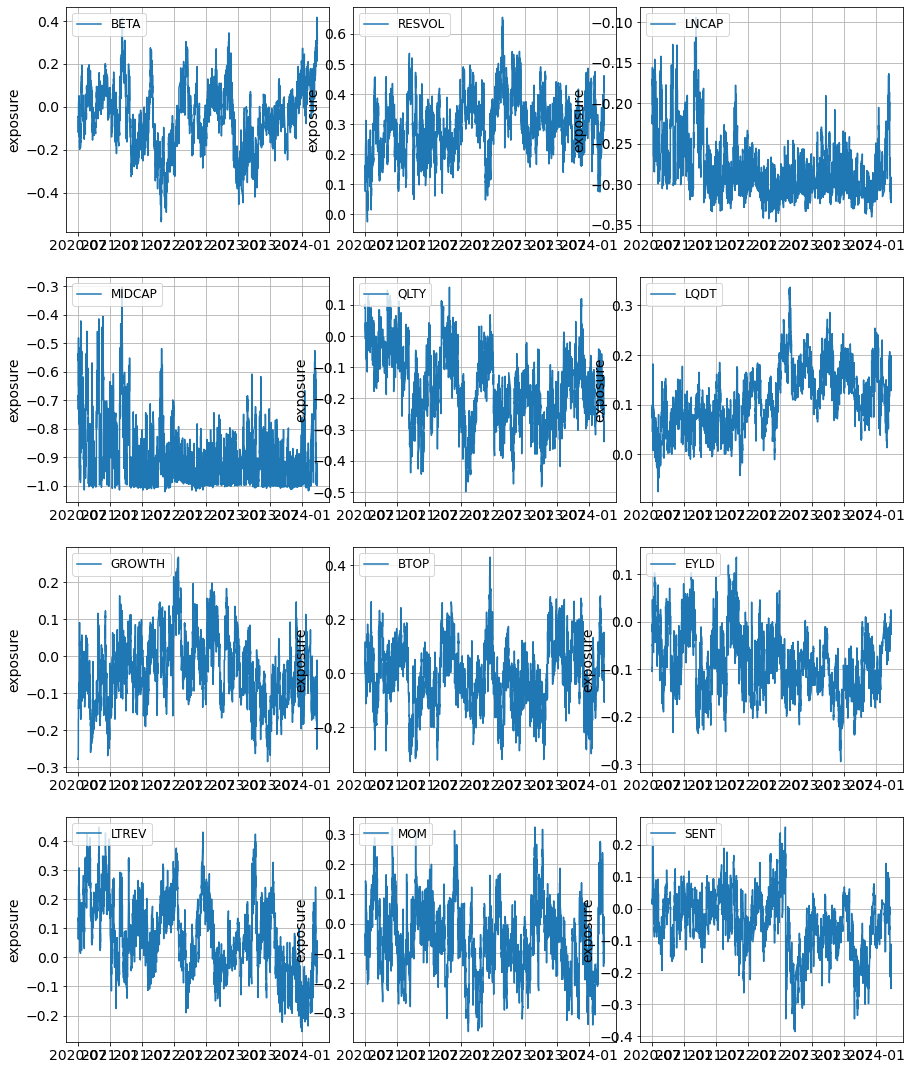

In [216]:
plot_risk_profiles(risk_profile_port)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

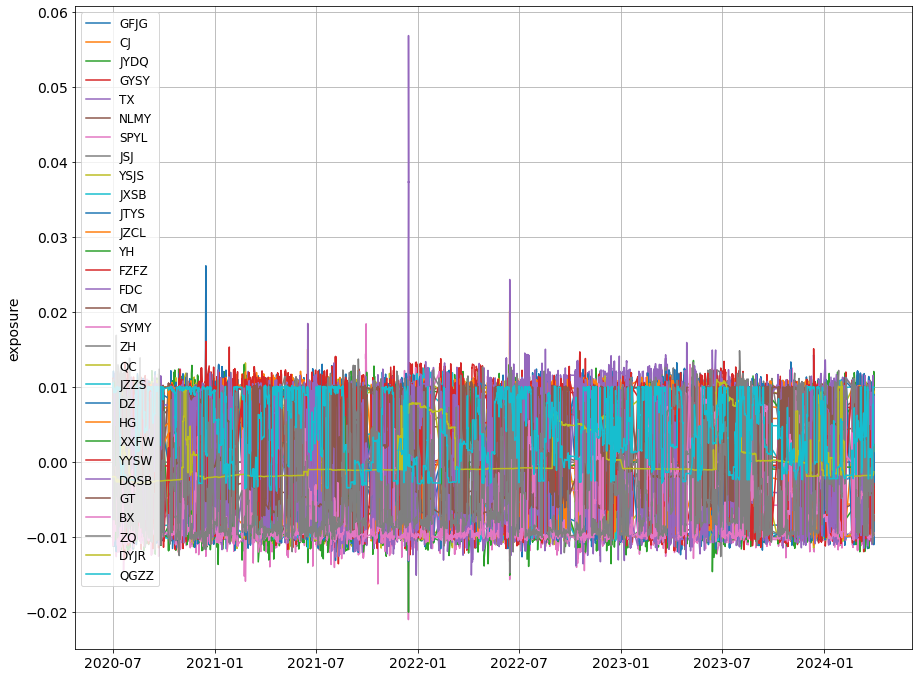

In [217]:
plot_risk_profiles_ind(risk_profile_port)

In [218]:
port_factor_rets = (risk_profile_port*factor_rets).dropna()

<AxesSubplot: xlabel='datetime'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

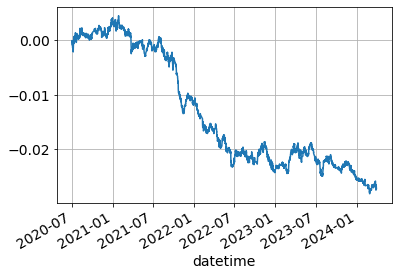

In [219]:
port_factor_rets[ind_factors].sum(axis=1).cumsum().plot()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

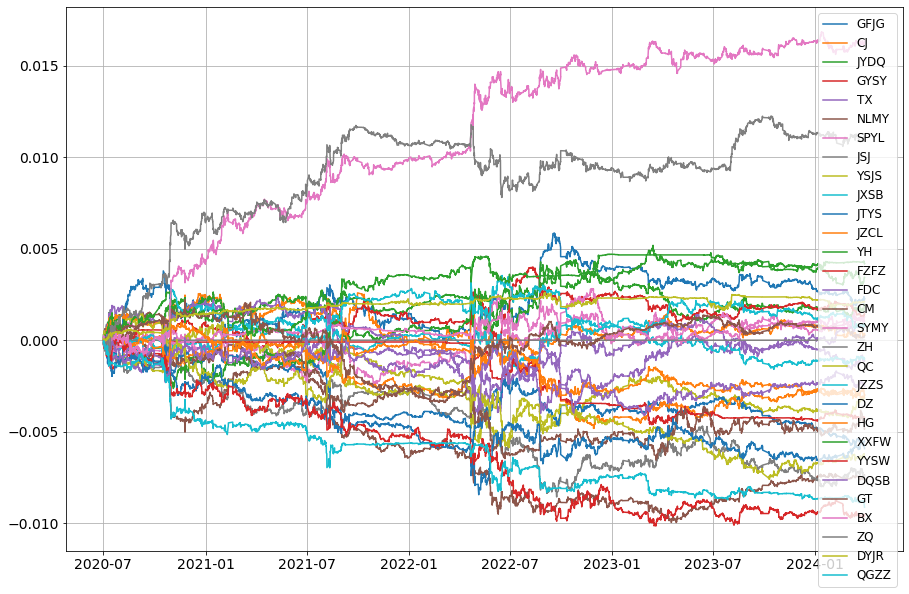

In [220]:
fig = plt.figure(figsize=(15,10))
plt.plot(port_factor_rets[ind_factors].cumsum())
plt.legend(ind_factors)

<AxesSubplot: xlabel='datetime'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

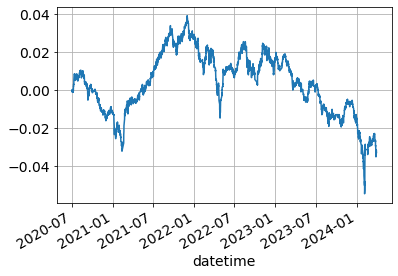

In [221]:
port_factor_rets[style_factors].sum(axis=1).cumsum().plot()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

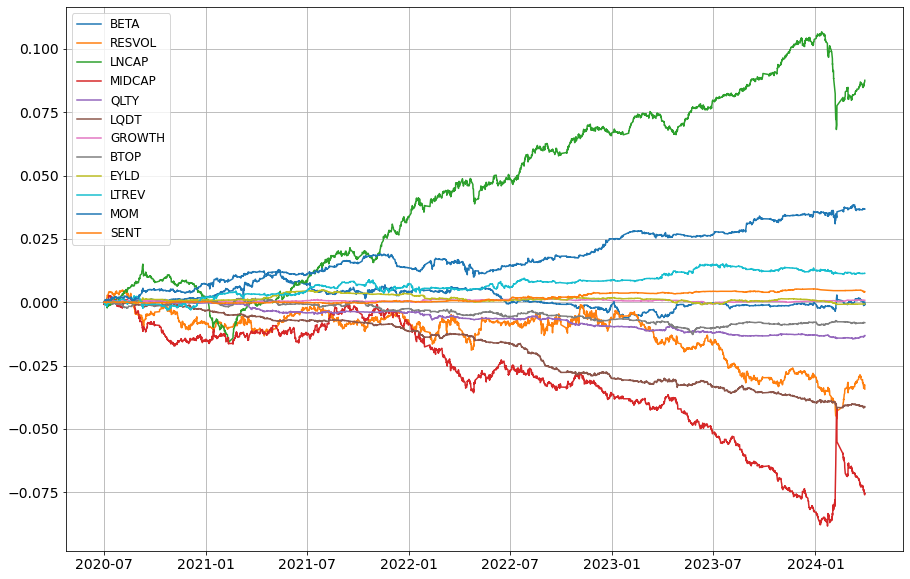

In [222]:
fig = plt.figure(figsize=(15,10))
plt.plot(port_factor_rets[[i for i in style_factors]].cumsum())
plt.legend(style_factors)

In [223]:
fee_execution = portfolio.groupby('datetime').agg({'fee':'sum'})
fee_misc = turnover[['abs_trade_weights']]

In [224]:
fee_execution[fee_execution.index.time==dt.time(9,30)]['fee'].describe()

count    911.000000
mean       0.000262
std        0.000486
min       -0.001491
25%       -0.000028
50%        0.000244
75%        0.000547
max        0.003403
Name: fee, dtype: float64

In [225]:
fee_execution['fee'].describe()

count    7288.000000
mean        0.000048
std         0.000215
min        -0.001491
25%        -0.000035
50%         0.000023
75%         0.000089
max         0.003403
Name: fee, dtype: float64

<AxesSubplot: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

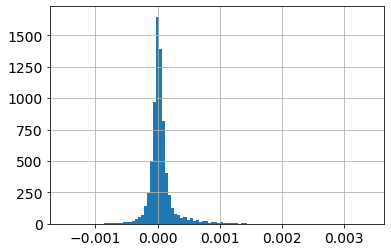

In [226]:
fee_execution['fee'].hist(bins=100)

In [227]:
fee_misc.loc[fee_misc.index<pd.datetime(2023,8,28),'abs_trade_weights'] = fee_misc.loc[fee_misc.index<pd.datetime(2023,8,28),'abs_trade_weights']*0.0014*0.5
fee_misc.loc[fee_misc.index>=pd.datetime(2023,8,28),'abs_trade_weights'] = fee_misc.loc[fee_misc.index>=pd.datetime(2023,8,28),'abs_trade_weights']*0.0009*0.5

/tmp/ipykernel_747219/1012205751.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  fee_misc.loc[fee_misc.index<pd.datetime(2023,8,28),'abs_trade_weights'] = fee_misc.loc[fee_misc.index<pd.datetime(2023,8,28),'abs_trade_weights']*0.0014*0.5
/tmp/ipykernel_747219/1012205751.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  fee_misc.loc[fee_misc.index>=pd.datetime(2023,8,28),'abs_trade_weights'] = fee_misc.loc[fee_misc.index>=pd.datetime(2023,8,28),'abs_trade_weights']*0.0009*0.5


In [228]:
fee = fee_execution['fee'] + fee_misc['abs_trade_weights']

In [229]:
fee.describe()

count    7288.000000
mean        0.000084
std         0.000222
min        -0.001421
25%        -0.000002
50%         0.000055
75%         0.000124
max         0.004103
dtype: float64

In [230]:
fee_table = pd.DataFrame(fee, columns=['fee'])
fee_table['interval'] = fee_table.index.time

array([[<AxesSubplot: title={'center': 'fee'}>]], dtype=object)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

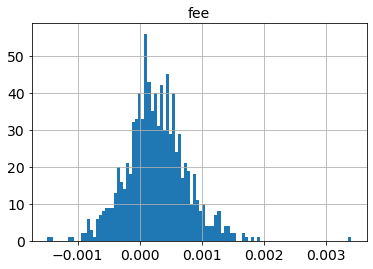

In [231]:
fee_execution[fee_execution.index.time == dt.time(9,30)].hist(bins=100)

array([[<AxesSubplot: title={'center': 'fee'}>]], dtype=object)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

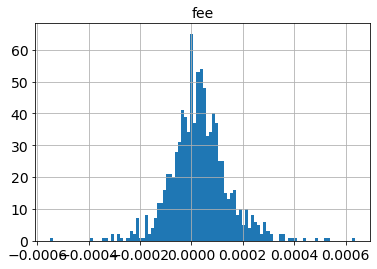

In [232]:
fee_execution[fee_execution.index.time == dt.time(11,30)].hist(bins=100)

array([[<AxesSubplot: title={'center': 'fee'}>]], dtype=object)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

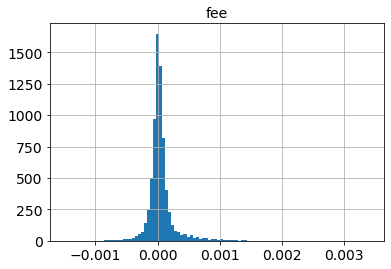

In [233]:
fee_execution.hist(bins=100)

Text(0.5, 1.0, 'Trading fees')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

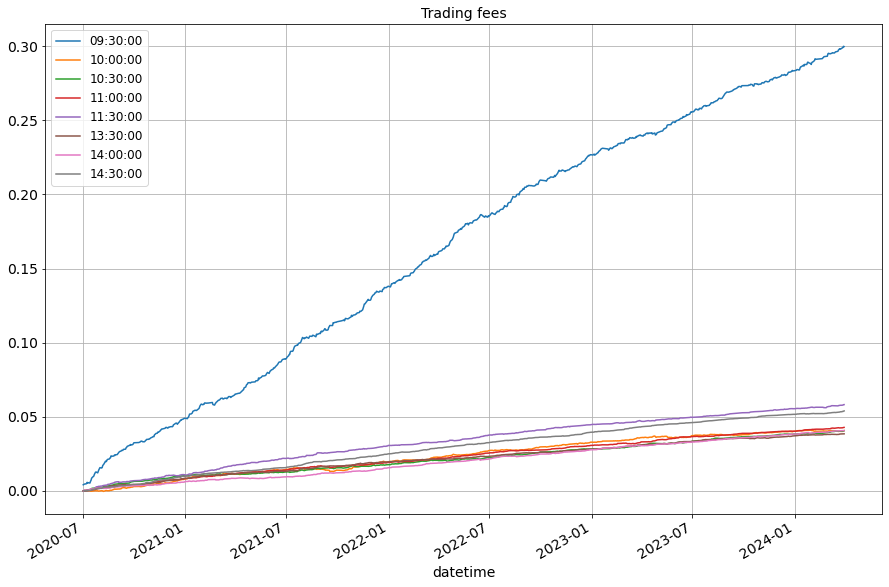

In [234]:
fig = plt.figure(figsize=(15,10))
for i in itvls:
    fee_table[fee_table['interval']==i]['fee'].cumsum().plot()
plt.legend(itvls)
plt.title('Trading fees')


In [235]:
ret = portfolio.groupby(['datetime']).agg({'ret':'sum'})

In [236]:
ret_table = (ret['ret']-fee)
ret_table = pd.DataFrame(ret_table, columns=['ret'])
ret_table['interval'] = fee_table.index.time

Text(0.5, 1.0, 'ret after fees')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

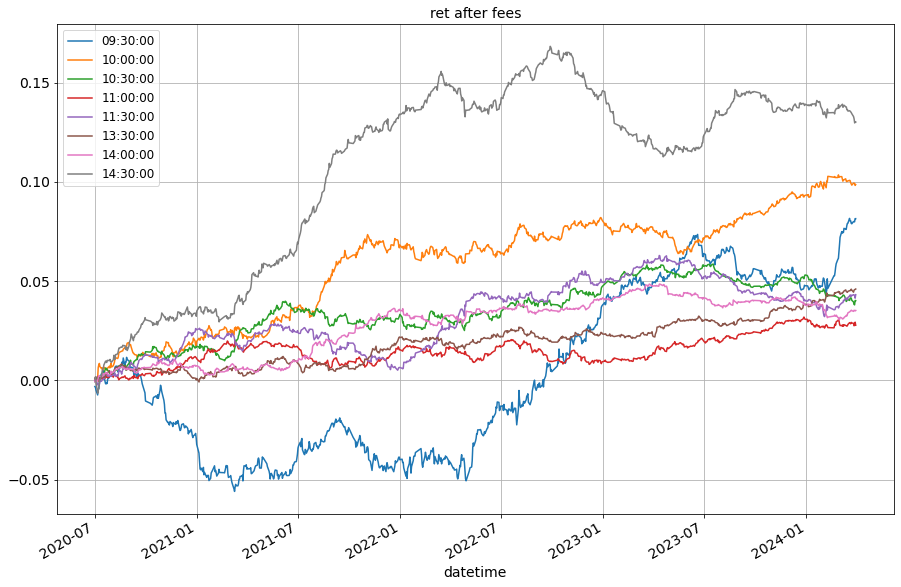

In [237]:
fig = plt.figure(figsize=(15,10))
for i in itvls:
    ret_table[ret_table['interval']==i]['ret'].cumsum().plot()
plt.legend(itvls)
plt.title('ret after fees')

In [238]:
ret_table = (ret['ret'])
ret_table = pd.DataFrame(ret_table, columns=['ret'])
ret_table['interval'] = fee_table.index.time

Text(0.5, 1.0, 'ret before fees')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

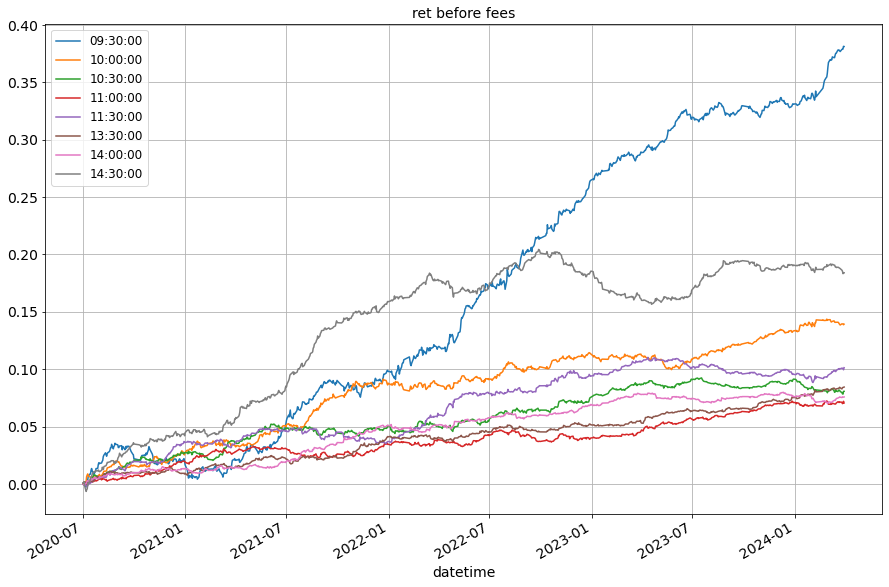

In [239]:
fig = plt.figure(figsize=(15,10))
for i in itvls:
    ret_table[ret_table['interval']==i]['ret'].cumsum().plot()
plt.legend(itvls)
plt.title('ret before fees')

<AxesSubplot: xlabel='datetime'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

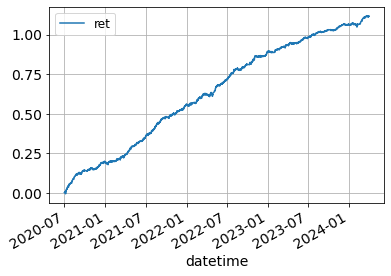

In [240]:
ret.cumsum().plot()

Text(0.5, 1.0, 'Trading cost')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

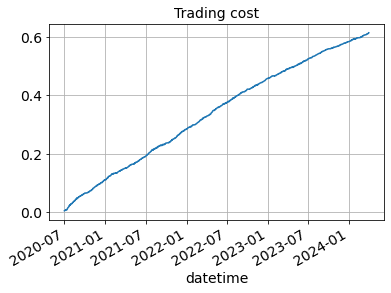

In [241]:
fee.cumsum().plot()
plt.title('Trading cost')

Text(0.5, 1.0, 'pure alpha ret')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

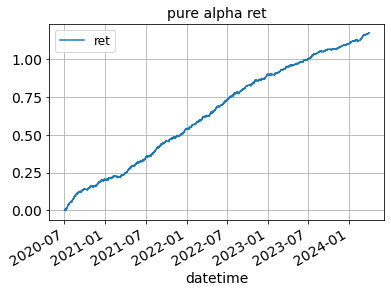

In [242]:
((ret-pd.DataFrame(port_factor_rets.sum(axis=1), columns=['ret'])).cumsum()).plot()
plt.title('pure alpha ret')

Text(0.5, 1.0, 'Factor ret')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

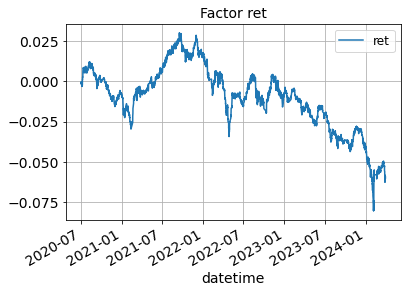

In [243]:
pd.DataFrame(port_factor_rets.sum(axis=1), columns=['ret']).cumsum().plot()
plt.title('Factor ret')

Text(0.5, 1.0, 'pure alpha ret - trading cost')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

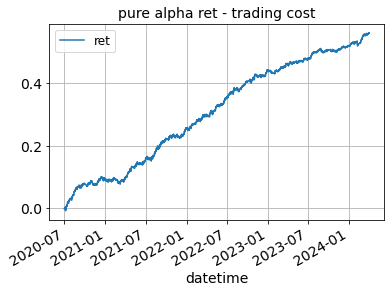

In [244]:
(ret-pd.DataFrame(port_factor_rets.sum(axis=1), columns=['ret']) - pd.DataFrame(fee, columns=['ret'])).cumsum().plot()
plt.title('pure alpha ret - trading cost')

In [245]:
def plot_portfolio_profiles_itvls(portfolio,ret, fee, turnover,alpha_name,ret_type='ret'):
    fig = plt.figure(figsize=(15,16))
    axx = plt.subplot2grid(shape=(3, 4), loc=(0, 0), colspan=4)
    axx.plot(ret.index, ret[ret_type].cumsum().values, label='Cumulative Returns')
    axx.plot(ret.index, (ret['ret']-fee).cumsum().values, label='Cumulative Returns after fee')
    axx.plot(fee.cumsum().index, -fee.cumsum().values, label='TC')
    axx.set_ylabel('Rets')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=3)
    axx = plt.subplot2grid(shape=(3, 4), loc=(1, 0), colspan=2)
    axx.plot(turnover.sum(axis=1).index, turnover.sum(axis=1).values, label='Turnover')
    axx.set_ylabel('Turnover')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

    axx = plt.subplot2grid(shape=(3, 4), loc=(1, 2), colspan=2)
    axx.hist(turnover.sum(axis=1).values, bins=100, label='Turnover distribution')
    axx.set_ylabel('Turnover distribution')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)

    axx = plt.subplot2grid(shape=(3, 4), loc=(2, 0), colspan=2)
    axx.plot(portfolio[abs(portfolio['weights'])>0].groupby('datetime')['code'].count().index, portfolio[abs(portfolio['weights'])>0].groupby('datetime')['code'].count().values, label='Number of stocks')
    axx.set_ylabel('Number of stocks')
    handles, labels = axx.get_legend_handles_labels()
    axx.legend(handles, labels, loc='upper left', ncol=1)
    
#     axx = plt.subplot2grid(shape=(3, 4), loc=(2, 2), colspan=2)
#     axx.hist(holding_periods['holding_days'].values, bins=500, label='Holding days')
#     axx.set_ylabel('Holding days')
#     axx.set_xlim(0,100)
#     handles, labels = axx.get_legend_handles_labels()
#     axx.legend(handles, labels, loc='upper left', ncol=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

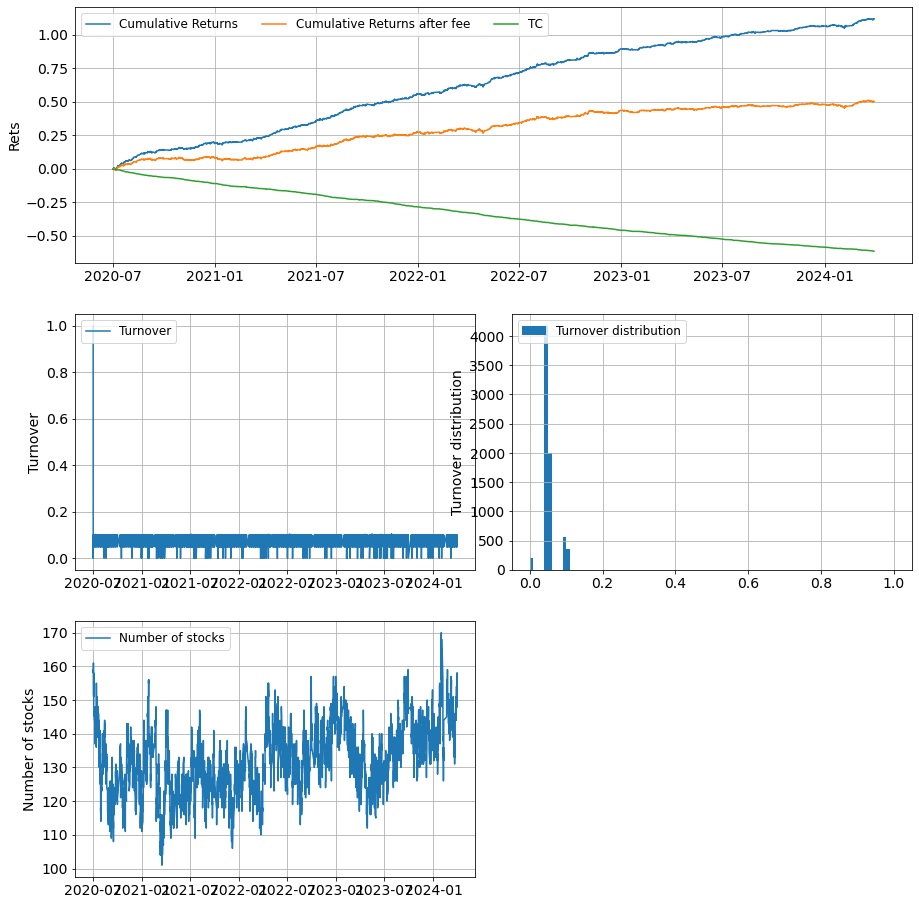

In [246]:
plot_portfolio_profiles_itvls(portfolio,ret,fee,turnover,'','ret')

In [247]:
df_daily = pd.DataFrame((ret['ret']-fee), columns=['cumret']).reset_index()
df_daily['date'] = df_daily['datetime'].dt.date
df_daily['date'] = pd.to_datetime(df_daily['date'])

In [248]:
df_daily['time'] = df_daily['datetime'].dt.time

In [249]:
# df_daily=df_daily[df_daily['date']>=pd.to_datetime(dt.date(2019,,1))]

In [250]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})

In [251]:
df = df.cumsum()

In [252]:
df['cumret'] = df['cumret']+1

In [253]:
# df_910 = df.copy()

In [254]:
# df_911 = pd.read_parquet('./Book911.Ver1_0_3.vol0.003.TC0.5.TO0.1.swu0.05.index_vol_pct0.2.parquet')

In [255]:
# ratio_910 = 0.5

In [256]:
# df = df_910.rename(columns={'cumret':'910'}).join(df_911.rename(columns={'cumret':'911'}))

In [257]:
# df['cumret'] = ratio_910* df['910'] + (1-ratio_910)*df['911']

In [258]:
# df.to_parquet('./Book910.Ver2_1_1.vol0.008.TC2_2.TO0.3_1.swu0.02.power2.parquet')

In [259]:
from gyqk_performance import PerformanceMeasure, ANNUALIZATION_FACTORS, DAILY

In [260]:
pp = PerformancePlot(df['cumret'].values, df.index, single_interest=True)


================ Drawdown table head ================
   start  end      size  duration start_date   end_date
0      1    4  0.010971         4 2020-07-02 2020-07-07
1     11   12  0.001853         2 2020-07-16 2020-07-17
2     15   16  0.000363         2 2020-07-22 2020-07-23
3     21   23  0.003757         3 2020-07-30 2020-08-03
4     27   29  0.000707         3 2020-08-07 2020-08-11

================ Top 5 drawdowns by size and duration ================
The largest 5 drawdowns by size:
2023-12-07~2024-02-28, 53 trading days, 3.5%
2022-03-24~2022-05-10, 29 trading days, 3.4%
2020-12-14~2021-03-29, 70 trading days, 2.6%
2020-10-27~2020-12-09, 32 trading days, 2.2%
2022-11-04~2022-12-27, 38 trading days, 1.9%
The largest 5 drawdowns by duration:
2020-12-14~2021-03-29, 70 trading days, 2.6%
2023-08-17~2023-11-08, 54 trading days, 1.6%
2023-12-07~2024-02-28, 53 trading days, 3.5%
2022-11-04~2022-12-27, 38 trading days, 1.9%
2022-08-02~2022-09-20, 35 trading days, 1.8%

================

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

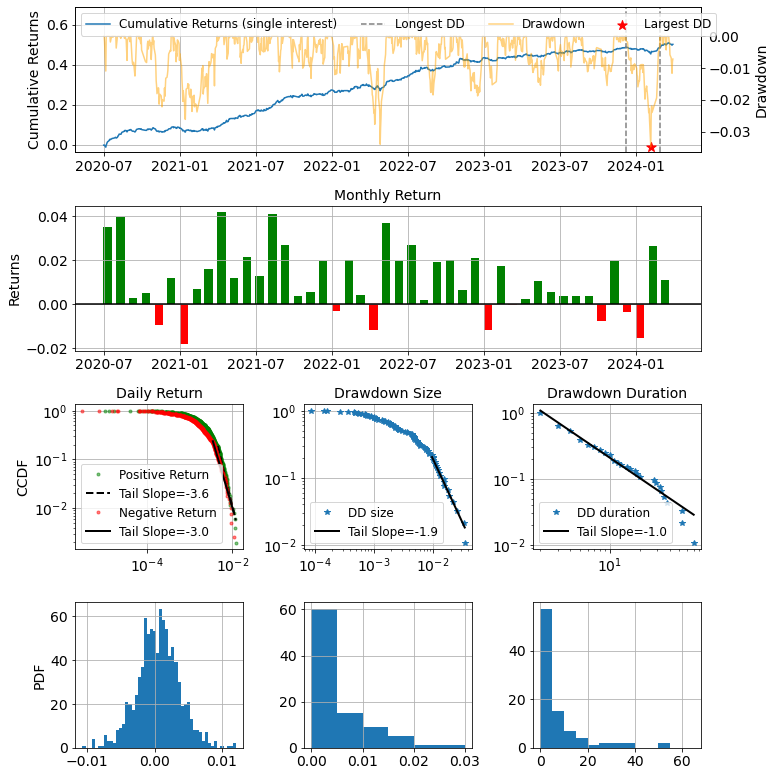

In [261]:
pp.get_report()

In [262]:
pm = PerformanceMeasure(df['cumret'].values, df.index, single_interest_in=True, single_interest_out=False, benchmark=np.ones(len(df.values)))

In [263]:
pm.print_stats()


================ Strategy Performance ================
return_rate: 64.52%
annual_return: 14.76%
annual_volatility: 5.00%
max_drawdown: 3.43%
sharpe: 2.95
annual_downside_risk: 3.51%
sortino: 4.20
calmar: 4.30
win_rate: 56.2%


In [264]:
# df.to_parquet('./hs300_20220101_20231113.parquet')

In [265]:
# df.to_parquet('./zhenxuan_20220101_20231113.parquet')

In [189]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})
df = df.cumsum()
df['cumret'] = df['cumret']+1

In [190]:
df = df[df.index>= pd.to_datetime(dt.date(2020,1,1))].copy()
df = df[df.index< pd.to_datetime(dt.date(2021,1,1))].copy()
df= df-df.iloc[0]+1

/tmp/ipykernel_747219/949760661.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])


多因子版策略：
The largest 5 drawdowns by size:
2020-10-29~2020-12-11, 32 trading days, 1.8%
2020-12-14~2020-12-31, 14 trading days, 1.1%
2020-09-04~2020-09-18, 11 trading days, 1.1%
2020-07-01~2020-07-06, 4 trading days, 0.9%
2020-09-25~2020-10-23, 15 trading days, 0.9%
The largest 5 drawdowns by duration:
2020-10-29~2020-12-11, 32 trading days, 1.8%
2020-09-25~2020-10-23, 15 trading days, 0.9%
2020-12-14~2020-12-31, 14 trading days, 1.1%
2020-09-04~2020-09-18, 11 trading days, 1.1%
2020-07-01~2020-07-06, 4 trading days, 0.9%
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

return_rate: 7.45%
annual_return: 15.59%
annual_volatility: 4.63%
max_drawdown: 1.81%
sharpe: 3.15
annual_downside_risk: 3.36%
sortino: 4.34
calmar: 8.61
win_rate: 60.0%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

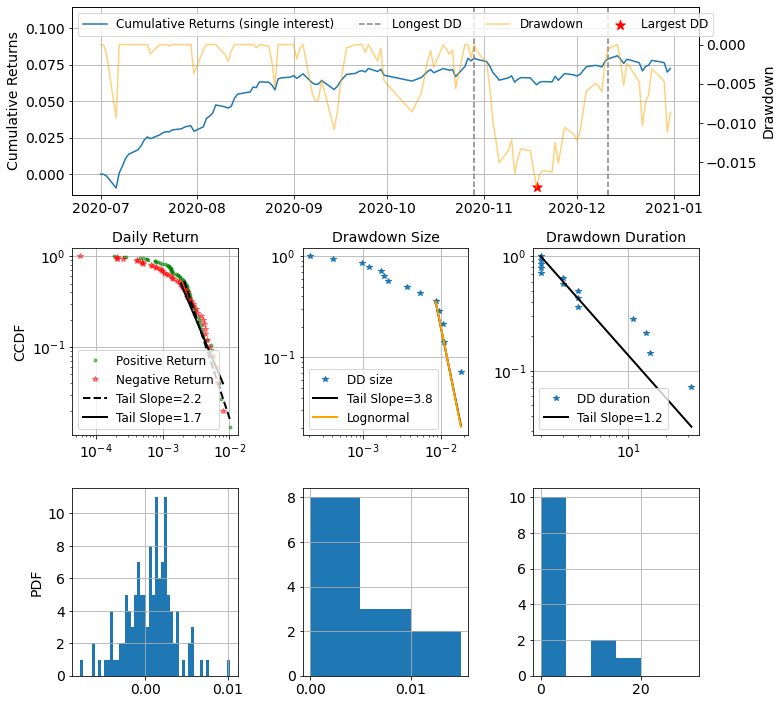

In [191]:
# input
print("多因子版策略：")
arr = df['cumret'].values
index = df.index
single_interest = True
if single_interest:
    rtrn = np.diff(arr)
else:
    rtrn = arr[1:]/arr[:-1]-1

# drawdown
DD_df, drawdown_series = calc_drawdown_table(arr, index, single_interest)
# print(DD_df.head())

# 前五大回撤
print_largest_drawdowns(DD_df, 5, 'size')
print_largest_drawdowns(DD_df, 5, 'duration')

# 画图
fig = plot_performance(arr, index, single_interest, rtrn, DD_df, drawdown_series)

# 统计指标

# rtrn已经是超额了，因此benchmark设置为np.zeros
# 第三项为无风险利率，暂时设置为0
risk = Risk(rtrn.astype('float'), np.zeros(len(rtrn)), 0, period='daily')
risk = pd.Series(risk.all())
for _s in s_format.keys():
    print("%s: %s"%(_s, s_format[_s].format(risk[_s])))

In [192]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})
df = df.cumsum()
df['cumret'] = df['cumret']+1

In [193]:
df = df[df.index>= pd.to_datetime(dt.date(2021,1,1))].copy()
df = df[df.index< pd.to_datetime(dt.date(2022,1,1))].copy()
df= df-df.iloc[0]+1

/tmp/ipykernel_747219/949760661.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found becaus

多因子版策略：
The largest 5 drawdowns by size:
2021-10-20~2021-12-20, 44 trading days, 1.5%
2021-01-04~2021-02-19, 30 trading days, 1.4%
2021-03-17~2021-03-26, 8 trading days, 1.3%
2021-03-05~2021-03-10, 4 trading days, 0.9%
2021-09-23~2021-09-27, 3 trading days, 0.9%
The largest 5 drawdowns by duration:
2021-10-20~2021-12-20, 44 trading days, 1.5%
2021-01-04~2021-02-19, 30 trading days, 1.4%
2021-05-24~2021-06-21, 20 trading days, 0.8%
2021-07-05~2021-07-20, 12 trading days, 0.7%
2021-03-17~2021-03-26, 8 trading days, 1.3%
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

return_rate: 19.29%
annual_return: 20.16%
annual_volatility: 5.12%
max_drawdown: 1.48%
sharpe: 3.61
annual_downside_risk: 3.61%
sortino: 5.12
calmar: 13.63
win_rate: 59.9%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

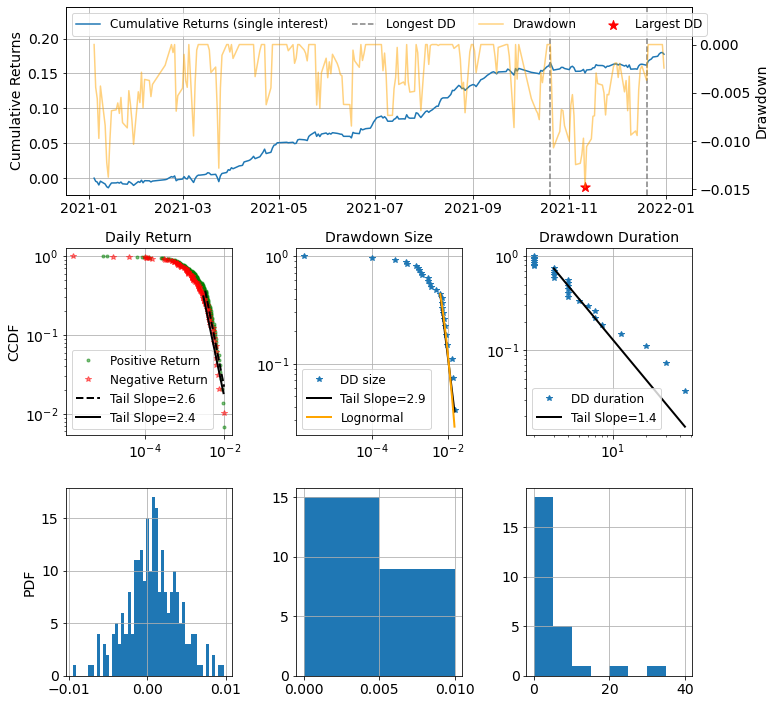

In [194]:
# input
print("多因子版策略：")
arr = df['cumret'].values
index = df.index
single_interest = True
if single_interest:
    rtrn = np.diff(arr)
else:
    rtrn = arr[1:]/arr[:-1]-1

# drawdown
DD_df, drawdown_series = calc_drawdown_table(arr, index, single_interest)
# print(DD_df.head())

# 前五大回撤
print_largest_drawdowns(DD_df, 5, 'size')
print_largest_drawdowns(DD_df, 5, 'duration')

# 画图
fig = plot_performance(arr, index, single_interest, rtrn, DD_df, drawdown_series)

# 统计指标

# rtrn已经是超额了，因此benchmark设置为np.zeros
# 第三项为无风险利率，暂时设置为0
risk = Risk(rtrn.astype('float'), np.zeros(len(rtrn)), 0, period='daily')
risk = pd.Series(risk.all())
for _s in s_format.keys():
    print("%s: %s"%(_s, s_format[_s].format(risk[_s])))

In [195]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})
df = df.cumsum()
df['cumret'] = df['cumret']+1

In [196]:
df = df[df.index>= pd.to_datetime(dt.date(2022,1,1))].copy()
df = df[df.index< pd.to_datetime(dt.date(2023,1,1))].copy()
df= df-df.iloc[0]+1

/tmp/ipykernel_747219/949760661.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

多因子版策略：
The largest 5 drawdowns by size:
2022-03-24~2022-05-05, 26 trading days, 2.6%
2022-11-04~2022-12-30, 41 trading days, 2.1%
2022-08-15~2022-09-21, 27 trading days, 1.5%
2022-01-04~2022-02-22, 31 trading days, 1.4%
2022-02-25~2022-03-09, 9 trading days, 1.0%
The largest 5 drawdowns by duration:
2022-11-04~2022-12-30, 41 trading days, 2.1%
2022-01-04~2022-02-22, 31 trading days, 1.4%
2022-08-15~2022-09-21, 27 trading days, 1.5%
2022-03-24~2022-05-05, 26 trading days, 2.6%
2022-05-23~2022-06-10, 14 trading days, 0.6%
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

return_rate: 14.87%
annual_return: 15.60%
annual_volatility: 5.28%
max_drawdown: 2.56%
sharpe: 2.77
annual_downside_risk: 3.66%
sortino: 3.99
calmar: 6.10
win_rate: 57.7%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

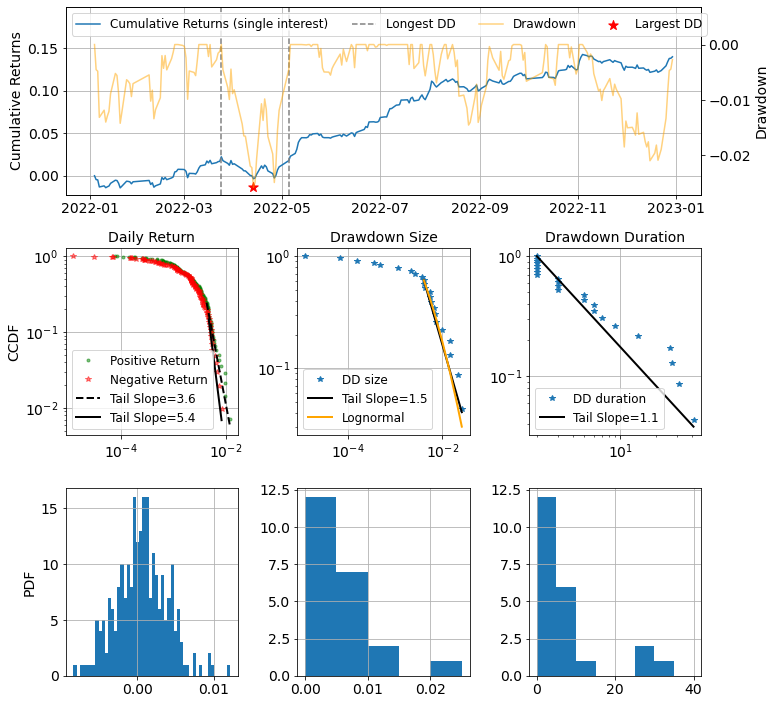

In [197]:
# input
print("多因子版策略：")
arr = df['cumret'].values
index = df.index
single_interest = True
if single_interest:
    rtrn = np.diff(arr)
else:
    rtrn = arr[1:]/arr[:-1]-1

# drawdown
DD_df, drawdown_series = calc_drawdown_table(arr, index, single_interest)
# print(DD_df.head())

# 前五大回撤
print_largest_drawdowns(DD_df, 5, 'size')
print_largest_drawdowns(DD_df, 5, 'duration')

# 画图
fig = plot_performance(arr, index, single_interest, rtrn, DD_df, drawdown_series)

# 统计指标

# rtrn已经是超额了，因此benchmark设置为np.zeros
# 第三项为无风险利率，暂时设置为0
risk = Risk(rtrn.astype('float'), np.zeros(len(rtrn)), 0, period='daily')
risk = pd.Series(risk.all())
for _s in s_format.keys():
    print("%s: %s"%(_s, s_format[_s].format(risk[_s])))

In [198]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})
df = df.cumsum()
df['cumret'] = df['cumret']+1

In [199]:
df = df[df.index>= pd.to_datetime(dt.date(2023,1,1))].copy()
df = df[df.index< pd.to_datetime(dt.date(2024,1,1))].copy()
df= df-df.iloc[0]+1

/tmp/ipykernel_747219/949760661.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

多因子版策略：
The largest 5 drawdowns by size:
2023-04-12~2023-05-26, 30 trading days, 1.2%
2023-06-19~2023-07-13, 17 trading days, 0.9%
2023-12-07~2023-12-29, 17 trading days, 0.9%
2023-10-19~2023-11-07, 14 trading days, 0.9%
2023-03-13~2023-03-21, 7 trading days, 0.9%
The largest 5 drawdowns by duration:
2023-04-12~2023-05-26, 30 trading days, 1.2%
2023-08-25~2023-09-27, 24 trading days, 0.8%
2023-12-07~2023-12-29, 17 trading days, 0.9%
2023-06-19~2023-07-13, 17 trading days, 0.9%
2023-10-19~2023-11-07, 14 trading days, 0.9%
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

return_rate: 8.04%
annual_return: 8.42%
annual_volatility: 3.40%
max_drawdown: 1.16%
sharpe: 2.40
annual_downside_risk: 2.40%
sortino: 3.39
calmar: 7.26
win_rate: 56.8%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

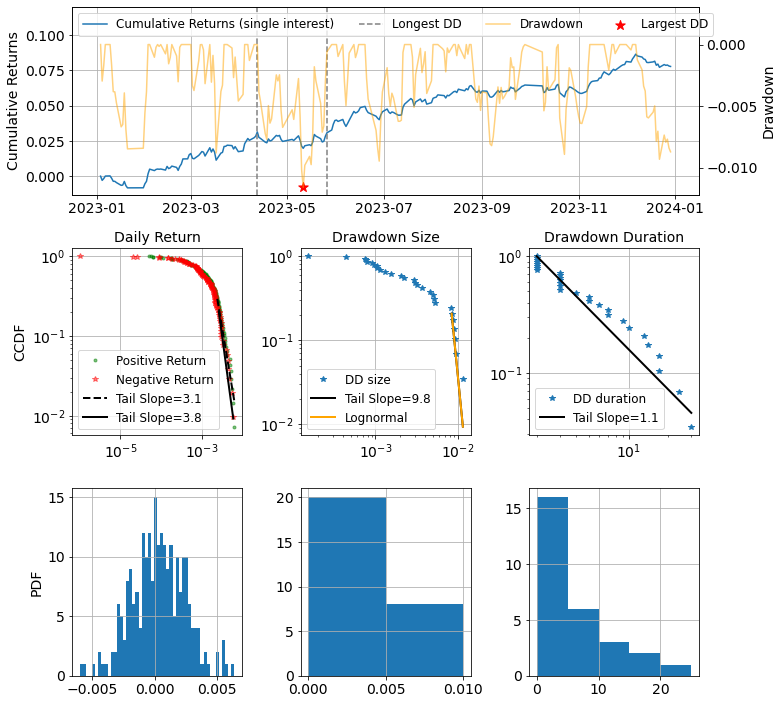

In [200]:
# input
print("多因子版策略：")
arr = df['cumret'].values
index = df.index
single_interest = True
if single_interest:
    rtrn = np.diff(arr)
else:
    rtrn = arr[1:]/arr[:-1]-1

# drawdown
DD_df, drawdown_series = calc_drawdown_table(arr, index, single_interest)
# print(DD_df.head())

# 前五大回撤
print_largest_drawdowns(DD_df, 5, 'size')
print_largest_drawdowns(DD_df, 5, 'duration')

# 画图
fig = plot_performance(arr, index, single_interest, rtrn, DD_df, drawdown_series)

# 统计指标

# rtrn已经是超额了，因此benchmark设置为np.zeros
# 第三项为无风险利率，暂时设置为0
risk = Risk(rtrn.astype('float'), np.zeros(len(rtrn)), 0, period='daily')
risk = pd.Series(risk.all())
for _s in s_format.keys():
    print("%s: %s"%(_s, s_format[_s].format(risk[_s])))

In [201]:
df = df_daily.groupby(['date']).agg({'cumret':'sum'})
df = df.cumsum()
df['cumret'] = df['cumret']+1

In [202]:
df = df[df.index>= pd.to_datetime(dt.date(2024,1,1))].copy()
df = df[df.index< pd.to_datetime(dt.date(2025,1,1))].copy()
df= df-df.iloc[0]+1

/tmp/ipykernel_747219/949760661.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddlist = np.array([drawdown_series[x[0]:(x[1]+1)] for x in DD])


/home/sihang/anaconda3/lib/python3.9/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were foun

多因子版策略：
The largest 5 drawdowns by size:
2024-01-15~2024-02-22, 23 trading days, 2.1%
2024-03-19~2024-03-29, 9 trading days, 0.6%
2024-01-02~2024-01-10, 7 trading days, 0.6%
2024-03-08~2024-03-14, 5 trading days, 0.5%
2024-02-27~2024-02-28, 2 trading days, 0.2%
The largest 5 drawdowns by duration:
2024-01-15~2024-02-22, 23 trading days, 2.1%
2024-03-19~2024-03-29, 9 trading days, 0.6%
2024-01-02~2024-01-10, 7 trading days, 0.6%
2024-03-08~2024-03-14, 5 trading days, 0.5%
2024-03-04~2024-03-06, 3 trading days, 0.1%
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

return_rate: 2.72%
annual_return: 12.57%
annual_volatility: 5.10%
max_drawdown: 2.10%
sharpe: 2.35
annual_downside_risk: 3.61%
sortino: 3.31
calmar: 5.98
win_rate: 59.6%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

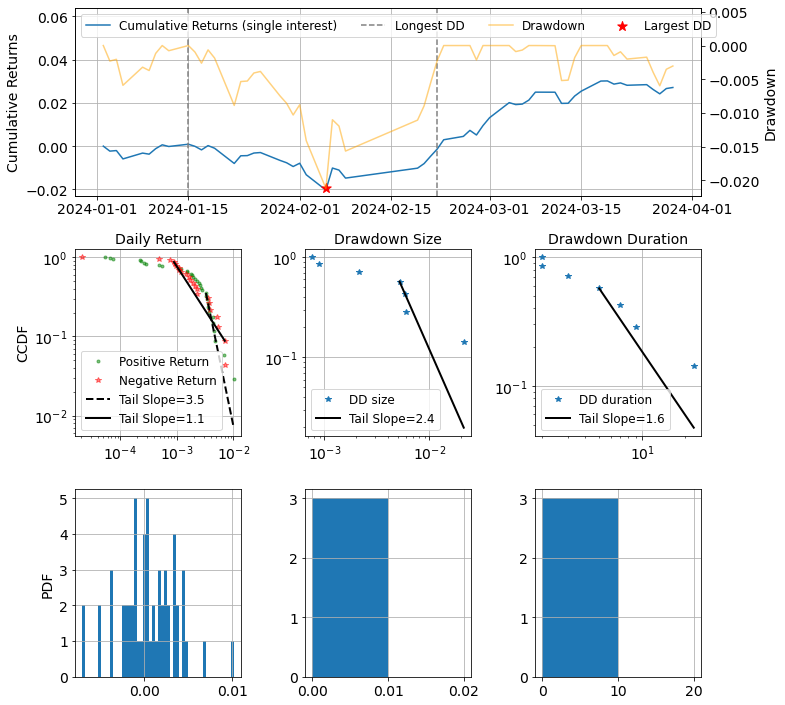

In [203]:
# input
print("多因子版策略：")
arr = df['cumret'].values
index = df.index
single_interest = True
if single_interest:
    rtrn = np.diff(arr)
else:
    rtrn = arr[1:]/arr[:-1]-1

# drawdown
DD_df, drawdown_series = calc_drawdown_table(arr, index, single_interest)
# print(DD_df.head())

# 前五大回撤
print_largest_drawdowns(DD_df, 5, 'size')
print_largest_drawdowns(DD_df, 5, 'duration')

# 画图
fig = plot_performance(arr, index, single_interest, rtrn, DD_df, drawdown_series)

# 统计指标

# rtrn已经是超额了，因此benchmark设置为np.zeros
# 第三项为无风险利率，暂时设置为0
risk = Risk(rtrn.astype('float'), np.zeros(len(rtrn)), 0, period='daily')
risk = pd.Series(risk.all())
for _s in s_format.keys():
    print("%s: %s"%(_s, s_format[_s].format(risk[_s])))

In [204]:
df

,cumret
date,
2024-01-02,1.000000
2024-01-03,0.997698
2024-01-04,0.997957
2024-01-05,0.994104
2024-01-08,0.996791
2024-01-09,0.996297
2024-01-10,0.998833
2024-01-11,1.000609
2024-01-12,0.999840
